In [1]:
from tunable_agents import utility, main
import utils
import gin
import numpy as np
import tensorflow as tf
from tf_agents.environments import tf_py_environment
from tf_agents.policies import py_tf_eager_policy
from tunable_agents.environments.gathering_env import gathering_env
from tf_agents.utils import common
from tf_agents.agents import data_converter
import matplotlib.pyplot as plt
import os

%matplotlib inline
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

In [2]:
absolute_path = "C:/Users/maler/Federico/Università/Master/Tesi"
configs_dir = "C:/Users/maler/Google Drive/Personale/Università/Master/Tesi/Code/tunable-agents-MORL/configs/"
root_dir = absolute_path + "/experiments_results"
experiment_name = "gathering_replication"
experiment_dir = "C:/Users/maler/Google Drive/Personale/Università/Master/Tesi/Code/experiments_results/" + experiment_name
policy_dir = os.path.join(root_dir, experiment_name, "policy")

gin_files = [configs_dir + "envs/gathering_replication_env.gin"]
gin_files += [configs_dir + "gathering_replication.gin", configs_dir + "qnets/replication_qnet.gin"]
# gin_files = [configs_dir + "envs/gathering_fixed_env.gin"]
gin_bindings = []
utility.load_gin_configs(gin_files, gin_bindings)

In [3]:
env = gathering_env.GatheringWrapper(utility_repr=np.array([1,5,3,4,5,6], dtype=np.float32))
env = gathering_env.GatheringWrapper()
tf_env = tf_py_environment.TFPyEnvironment(env)
#env = gathering_env.GatheringWrapper(cumulative_rewards_flag=True)

train_step = tf.Variable(0, trainable=False, name='global_step', dtype=tf.int64)
epoch_counter = tf.Variable(0, trainable=False, name='Epoch', dtype=tf.int64)
decaying_epsilon = utility.decaying_epsilon(step=epoch_counter)
tf_agent = utility.create_agent(environment=tf_env, decaying_epsilon=decaying_epsilon, train_step_counter=train_step)

replay_buffer = utility.create_replay_buffer(data_spec=tf_agent.collect_data_spec,
                                             batch_size=tf_env.batch_size)

In [4]:
rb_checkpoint_dir = os.path.join(experiment_dir, 'checkpoints', 'rb')
rb_checkpointer = common.Checkpointer(ckpt_dir=rb_checkpoint_dir,
                                        max_to_keep=1,
                                        replay_buffer=replay_buffer)

In [5]:
dataset = replay_buffer.as_dataset(single_deterministic_pass=False).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.


Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.


In [6]:
for data in dataset:
    break

In [7]:
print(tf_agent.collect_data_spec)

Trajectory(step_type=TensorSpec(shape=(), dtype=tf.int32, name='step_type'), observation=DictWrapper({'state_obs': TensorSpec(shape=(8, 8, 9), dtype=tf.float32, name=None), 'utility_representation': TensorSpec(shape=(4,), dtype=tf.float32, name=None)}), action=BoundedTensorSpec(shape=(), dtype=tf.int32, name=None, minimum=array(0), maximum=array(4)), policy_info=(), next_step_type=TensorSpec(shape=(), dtype=tf.int32, name='step_type'), reward=TensorSpec(shape=(), dtype=tf.float32, name='reward'), discount=BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)))


In [24]:
print(data[0].discount.numpy())
print(data[0].step_type.numpy())

[[0.99 0.99]
 [0.99 0.99]
 [0.99 0.99]
 [0.99 0.99]
 [0.99 0.99]
 [0.99 0.  ]
 [0.99 0.99]
 [0.   1.  ]
 [1.   0.99]
 [0.99 0.99]
 [0.99 0.99]
 [0.99 0.99]
 [0.99 0.99]
 [0.99 0.  ]
 [0.99 0.99]
 [0.99 0.99]
 [1.   0.99]
 [0.99 0.99]
 [0.99 0.99]
 [0.99 0.99]
 [0.99 0.99]
 [0.99 0.99]
 [0.99 0.99]
 [0.99 0.  ]
 [0.99 0.99]
 [0.99 0.99]
 [0.99 0.99]
 [0.99 0.  ]
 [0.99 0.99]
 [0.99 0.99]
 [0.99 0.99]
 [1.   0.99]]
[[1 1]
 [1 1]
 [0 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [0 2]
 [2 0]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [2 0]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [0 1]
 [0 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [2 0]]


[[0.125 0.5   0.5   0.25 ]
 [0.125 0.5   0.5   0.25 ]]


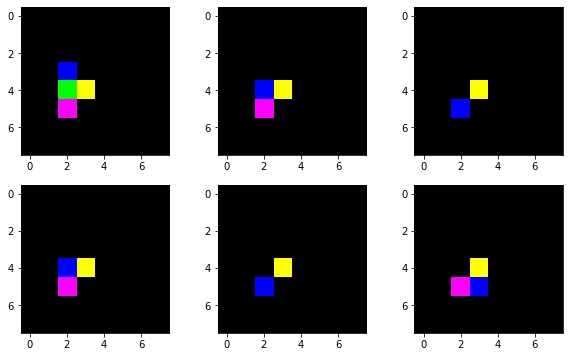

In [23]:
print(data[0].observation['utility_representation'].numpy()[5])

plt.figure(figsize=(10, 6))
plt.subplot(2,3,1)
plt.imshow(data[0].observation['state_obs'].numpy()[5][0][:,:,:3])
plt.subplot(2,3,2)
plt.imshow(data[0].observation['state_obs'].numpy()[5][0][:,:,3:6])
plt.subplot(2,3,3)
plt.imshow(data[0].observation['state_obs'].numpy()[5][0][:,:,6:])

plt.subplot(2,3,4)
plt.imshow(data[0].observation['state_obs'].numpy()[5][1][:,:,:3])
plt.subplot(2,3,5)
plt.imshow(data[0].observation['state_obs'].numpy()[5][1][:,:,3:6])
plt.subplot(2,3,6)
plt.imshow(data[0].observation['state_obs'].numpy()[5][1][:,:,6:])
plt.show()

In [ ]:
experience = data[0]
as_transition = data_converter.AsNStepTransition(
          self.data_context, gamma=gamma, n=n_step_update)

In [4]:
print(tf_agent._q_network._encoder.summary())
print(tf_agent._q_network.summary())

Model: "EncodingNetwork"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
ImagePreprocessing (Sequenti (1, 4096)                 611072    
_________________________________________________________________
utility_representation_Input multiple                  0         
_________________________________________________________________
concatenate (Concatenate)    multiple                  0         
_________________________________________________________________
flatten_1 (Flatten)          multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  262464    
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
dense_1 (Dense)              multiple              

In [7]:
print(tf_agent._q_network._encoder.layers)
tf_agent._q_network._encoder.layers[0].summary()


[<tensorflow.python.keras.engine.sequential.Sequential object at 0x00000232820622B0>, <tensorflow.python.keras.engine.sequential.Sequential object at 0x0000023282062850>, <tensorflow.python.keras.layers.merge.Concatenate object at 0x000002328206FCA0>, <tensorflow.python.keras.layers.core.Flatten object at 0x000002328206FFD0>, <tensorflow.python.keras.layers.core.Dense object at 0x00000232820785E0>, <tensorflow.python.keras.layers.core.Dropout object at 0x00000232820788B0>, <tensorflow.python.keras.layers.core.Dense object at 0x0000023282078910>, <tensorflow.python.keras.layers.core.Dropout object at 0x0000023282078CA0>]
Model: "ImagePreprocessing"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Convolutional (Conv2D)       (1, 6, 6, 256)            20992     
_________________________________________________________________
Dropout (Dropout)            (1, 6, 6, 256)            0         
______________

In [6]:
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv2D, Dropout, Dense, Flatten, Concatenate

In [7]:
image_input = Input(shape=(8,8,9))
# preference weights
weights_input = Input(shape=(4,)) # 4 weights

# Define Layers
x = image_input
x = Conv2D(256, (3, 3), activation='relu')(x)
x = Dropout(0.2)(x)
x = Conv2D(256, (3, 3), activation='relu')(x)
x = Dropout(0.2)(x)
x = Flatten()(x)
x = Concatenate()([x, weights_input])
# x = Dense(128, activation='relu')(x)
# x = Dropout(0.2)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)

x = Dense(5)(x)
outputs = x

# Build full model
model = keras.Model(inputs=[image_input, weights_input], outputs=outputs)

In [12]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 8, 8, 9)]    0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 6, 6, 256)    20992       input_1[0][0]                    
__________________________________________________________________________________________________
dropout_4 (Dropout)             (None, 6, 6, 256)    0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 4, 4, 256)    590080      dropout_4[0][0]                  
______________________________________________________________________________________________

In [ ]:
time_step = env.reset()
action = None
print(time_step.observation['utility_representation'])

In [ ]:
plt.figure(figsize=(15,7), dpi=100)
for i in range(1, 4):
    plt.subplot(1,3,i)
    image = time_step.observation['state_obs'][:, :, 3*(i-1):3*i]
    plt.imshow(image)
    plt.title('Utility: {}    Action: {}'.format(time_step.reward, action))
    plt.axis('off')
plt.show()
if time_step.is_last():
    print('END EPISODE')

In [ ]:
# 0: Do nothing
# 1: Left
# 2: Right
# 3: Down
# 4: Up
action = 3


time_step = env.step(action)

In [ ]:
print(env._prev_step_utility)